<a href="https://colab.research.google.com/github/enitin-agarwal/azureforaws/blob/master/MLDLADE_mimiciv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
!pip install torch_geometric
!pip install torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
from google.cloud import bigquery
from google.colab import auth
!pip install memory-profiler
from memory_profiler import profile  # Import memory_profiler


# Authenticate and Initialize BigQuery Client
auth.authenticate_user()
print('Authenticated')
client = bigquery.Client(project='ultimate-balm-449016-q6')

# Load Datasets from MIMIC-III Demo
def load_data(query):
    return client.query(query).to_dataframe()

#admissions = load_data("SELECT * FROM `physionet-data.mimiciii_demo.admissions` limit 10000")
#patients = load_data("SELECT * FROM `physionet-data.mimiciii_demo.patients`")
#prescriptions = load_data("SELECT * FROM `physionet-data.mimiciii_demo.prescriptions`")
#chartevents = load_data("SELECT * FROM `physionet-data.mimiciii_demo.chartevents` LIMIT 5000")
#labevents = load_data("SELECT * FROM `physionet-data.mimiciii_demo.labevents` LIMIT 5000")
#diagnoses = load_data("SELECT * FROM `physionet-data.mimiciii_demo.diagnoses_icd`")

admissions = load_data("SELECT SUBJECT_ID, HADM_ID, ADMITTIME FROM `physionet-data.mimiciii_demo.admissions` LIMIT 5000")
patients = load_data("SELECT SUBJECT_ID, DOB, GENDER FROM `physionet-data.mimiciii_demo.patients` LIMIT 5000")
prescriptions = load_data("SELECT SUBJECT_ID, HADM_ID, DRUG FROM `physionet-data.mimiciii_demo.prescriptions` WHERE DRUG IN ('vancomycin', 'gentamicin', 'tobramycin') LIMIT 5000")
chartevents = load_data("SELECT SUBJECT_ID, HADM_ID, ITEMID, VALUENUM FROM `physionet-data.mimiciii_demo.chartevents` WHERE ITEMID IN (211, 220045, 51, 442, 455, 6701, 220179, 220050, 8368, 8440, 8441, 8555, 220180, 220051) LIMIT 50000")
labevents = load_data("SELECT SUBJECT_ID, HADM_ID, ITEMID, VALUENUM FROM `physionet-data.mimiciii_demo.labevents` WHERE ITEMID = 50912 LIMIT 50000")
diagnoses = load_data("SELECT SUBJECT_ID, HADM_ID, ICD9_CODE FROM `physionet-data.mimiciii_demo.diagnoses_icd` WHERE ICD9_CODE IN ('5845', '5846', '5847', '5848', '5849') LIMIT 5000")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 27.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1E

Authenticated


In [83]:
# -*- coding: utf-8 -*-
"""MLDLADE_Enhanced.ipynb"""

# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
!pip install lifelines
from lifelines import CoxPHFitter
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, matthews_corrcoef, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.colab import auth

# Authenticate and Initialize BigQuery Client
auth.authenticate_user()
print('Authenticated')
client = bigquery.Client(project='ultimate-balm-449016-q6')

# Load Datasets with Optimized Queries
def load_data(query):
    return client.query(query).to_dataframe()

print("Loading optimized datasets...")
admissions = load_data("SELECT subject_id, hadm_id, admittime, admission_type, insurance FROM `physionet-data.mimiciv_3_1_hosp.admissions` LIMIT 20000")
patients = load_data("SELECT subject_id, DATE_SUB(DATE(anchor_year, 1, 1), INTERVAL anchor_age YEAR) AS dob, gender FROM `physionet-data.mimiciv_3_1_hosp.patients` LIMIT 20000")
# Add ICU-specific tables as needed, e.g., icustays
icustays = load_data("SELECT subject_id, hadm_id, stay_id, intime, outtime FROM `physionet-data.mimiciv_3_1_icu.icustays` LIMIT 5000")
#admissions = load_data("SELECT SUBJECT_ID, HADM_ID, ADMITTIME, ADMISSION_TYPE, INSURANCE FROM `physionet-data.mimiciii_demo.admissions` LIMIT 5000")
#patients = load_data("SELECT SUBJECT_ID, DOB, GENDER FROM `physionet-data.mimiciii_demo.patients` LIMIT 5000")
#prescriptions = load_data("SELECT SUBJECT_ID, HADM_ID, DRUG, STARTDATE FROM `physionet-data.mimiciii_demo.prescriptions` WHERE DRUG IN ('vancomycin', 'gentamicin', 'tobramycin') LIMIT 5000")
prescriptions = load_data("SELECT subject_id, hadm_id, drug, starttime FROM `physionet-data.mimiciv_3_1_hosp.prescriptions` WHERE drug IN ('vancomycin', 'gentamicin', 'tobramycin') LIMIT 20000")

#chartevents = load_data("SELECT SUBJECT_ID, HADM_ID, ITEMID, VALUENUM, CHARTTIME FROM `physionet-data.mimiciii_demo.chartevents` WHERE ITEMID IN (211, 220045, 51, 442, 455, 6701, 220179, 220050, 8368, 8440, 8441, 8555, 220180, 220051, 618, 220210, 646, 220277) LIMIT 50000")
chartevents = load_data("SELECT subject_id, hadm_id, itemid, valuenum, charttime FROM `physionet-data.mimiciv_3_1_icu.chartevents` WHERE itemid IN (211, 220045, 51, 442, 455, 6701, 220179, 220050, 8368, 8440, 8441, 8555, 220180, 220051, 618, 220210, 646, 220277) LIMIT 50000")

#labevents = load_data("SELECT SUBJECT_ID, HADM_ID, ITEMID, VALUENUM, CHARTTIME FROM `physionet-data.mimiciii_demo.labevents` WHERE ITEMID IN (50912, 51006, 50882, 50971) LIMIT 50000")  # Creatinine, BUN, Bicarbonate, Potassium
#diagnoses = load_data("SELECT SUBJECT_ID, HADM_ID, ICD9_CODE FROM `physionet-data.mimiciii_demo.diagnoses_icd` LIMIT 5000")
diagnoses = load_data("SELECT subject_id, hadm_id, icd_code FROM `physionet-data.mimiciv_3_1_hosp.diagnoses_icd` LIMIT 50000")

labevents = load_data("SELECT subject_id, hadm_id, charttime, itemid, valuenum FROM `physionet-data.mimiciv_3_1_hosp.labevents` WHERE itemid = 51006 LIMIT 50000")  # Example: Creatinine
chartevents_icu = load_data("SELECT ce.subject_id, ce.hadm_id, ce.stay_id, ce.charttime, ce.itemid, ce.valuenum FROM `physionet-data.mimiciv_3_1_icu.chartevents` ce   INNER JOIN `physionet-data.mimiciv_3_1_icu.icustays` ic ON ce.stay_id = ic.stay_id WHERE ce.itemid IN (211, 220045, 51, 442, 455, 6701, 220179, 220050, 8368, 8440, 8441, 8555, 220180, 220051, 618, 220210, 646, 220277) LIMIT 50000")
# Preprocess and merge data
data = admissions.merge(labevents, on=['subject_id', 'hadm_id'], how='left')
#X = preprocess_data(data)  # Your preprocessing function, updated for MIMIC-IV

# Train autoencoder and models as above


# Define AKI codes
aki_codes = ['5845', '5846', '5847', '5848', '5849']

# Process Data in Chunks
def process_chunk(chunk):
    # Merge with admissions and patients
    data = pd.merge(chunk, admissions, left_on=['subject_id', 'hadm_id'], right_on=['subject_id', 'hadm_id'], how='inner')
    data = pd.merge(data, patients, left_on='subject_id', right_on='subject_id', how='inner')  # Updated here as well

    #data = pd.merge(chunk, admissions, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
    #data = pd.merge(data, patients, on='SUBJECT_ID', how='inner')
    # Merge with prescriptions to include 'DRUG' column
    #data = pd.merge(data, prescriptions, on=['SUBJECT_ID', 'HADM_ID'], how='left')  # This line was added
    data = pd.merge(data, prescriptions, on=['subject_id', 'hadm_id'], how='left')  # This line was added


    # Feature Engineering
    #data['age'] = ((pd.to_datetime(data['ADMITTIME']) - pd.to_datetime(data['DOB'])).dt.days // 365).astype('int32')
    data['age'] = ((pd.to_datetime(data['admittime']) - pd.to_datetime(data['dob'])).dt.days // 365).astype('int32')

    #data['nephrotoxic_exposure'] = data['DRUG'].str.lower().isin(['vancomycin', 'gentamicin', 'tobramycin']).astype('int8')
    #data['nephrotoxic_exposure'] = data['DRUG'].str.lower().isin(['vancomycin', 'gentamicin', 'tobramycin']).fillna(0).astype('int8')
    data['nephrotoxic_exposure'] = data['drug'].str.lower().isin(['vancomycin', 'gentamicin', 'tobramycin']).fillna(0).astype('int8')

    #data['aki'] = data['ICD9_CODE'].apply(lambda x: 1 if str(x) in aki_codes else 0).astype('int8')
    data['aki'] = data['icd_code'].apply(lambda x: 1 if str(x) in aki_codes else 0).astype('int8')

    # Aggregate vitals and labs
    #vitals_agg = chartevents.groupby(['SUBJECT_ID', 'HADM_ID', 'ITEMID'])['VALUENUM'].agg(['mean', 'max', 'min', 'std']).unstack().reset_index()
    #labs_agg = labevents.groupby(['SUBJECT_ID', 'HADM_ID', 'ITEMID'])['VALUENUM'].agg(['mean', 'max', 'min', 'std']).unstack().reset_index()

    vitals_agg = chartevents.groupby(['subject_id', 'hadm_id', 'itemid'])['valuenum'].agg(['mean', 'max', 'min', 'std']).unstack().reset_index()
    labs_agg = labevents.groupby(['subject_id', 'hadm_id', 'itemid'])['valuenum'].agg(['mean', 'max', 'min', 'std']).unstack().reset_index()

    # Flatten the multi-level column index in vitals_agg and labs_agg, ensuring 'SUBJECT_ID' and 'HADM_ID' are present
    vitals_agg.columns = vitals_agg.columns.map(str)  # Convert all column names to strings
    #vitals_agg = vitals_agg.rename(columns={('SUBJECT_ID', ''): 'SUBJECT_ID', ('HADM_ID', ''): 'HADM_ID'})  # Rename if necessary
    #vitals_agg = vitals_agg.rename(columns={'SUBJECT_ID_': 'SUBJECT_ID', 'HADM_ID_': 'HADM_ID'})  # Rename flattened columns if necessary
    #vitals_agg = vitals_agg.rename(columns={ "('SUBJECT_ID', '')": 'SUBJECT_ID', "('HADM_ID', '')": 'HADM_ID'})  # Rename flattened columns

    vitals_agg = vitals_agg.rename(columns={'subject_id_': 'subject_id', 'hadm_id_': 'hadm_id'})  # Rename flattened columns if necessary
    vitals_agg = vitals_agg.rename(columns={ "('subject_id', '')": 'subject_id', "('hadm_id', '')": 'hadm_id'})  # Rename flattened columns

    labs_agg.columns = labs_agg.columns.map(str)
    #labs_agg = labs_agg.rename(columns={('SUBJECT_ID', ''): 'SUBJECT_ID', ('HADM_ID', ''): 'HADM_ID'})
    #labs_agg = labs_agg.rename(columns={'SUBJECT_ID_': 'SUBJECT_ID', 'HADM_ID_': 'HADM_ID'})  # Rename flattened columns if necessary
    #labs_agg = labs_agg.rename(columns={ "('SUBJECT_ID', '')": 'SUBJECT_ID', "('HADM_ID', '')": 'HADM_ID'})  # Rename flattened columns

    labs_agg = labs_agg.rename(columns={'subject_id_': 'subject_id', 'hadm_id_': 'hadm_id'})  # Rename flattened columns if necessary
    labs_agg = labs_agg.rename(columns={ "('subject_id', '')": 'subject_id', "('hadm_id', '')": 'hadm_id'})  # Rename flattened columns

    print(data.keys())
    print(vitals_agg.keys())

    # Now proceed with merging:
    #data = pd.merge(data, vitals_agg, on=['SUBJECT_ID', 'HADM_ID'], how='left')
    #data = pd.merge(data, labs_agg, on=['SUBJECT_ID', 'HADM_ID'], how='left')# Aggregate vitals and labs

    #data = pd.merge(data, chartevents[['SUBJECT_ID', 'HADM_ID', 'CHARTTIME']].drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID'], keep='first'),
     #               on=['SUBJECT_ID', 'HADM_ID'], how='left')

    data = pd.merge(data, vitals_agg, on=['subject_id', 'hadm_id'], how='left')
    data = pd.merge(data, labs_agg, on=['subject_id', 'hadm_id'], how='left')# Aggregate vitals and labs

    data = pd.merge(data, chartevents_icu[['subject_id', 'hadm_id', 'charttime']].drop_duplicates(subset=['subject_id', 'hadm_id'], keep='first'),
                    on=['subject_id', 'hadm_id'], how='left')

    # Time-based feature: Time from admission to first lab
    #data['time_to_lab'] = (pd.to_datetime(data['CHARTTIME']) - pd.to_datetime(data['ADMITTIME'])).dt.total_seconds() / 3600
    #data['time_to_lab'] = data['time_to_lab'].fillna(data['time_to_lab'].mean()).astype('float32')
    #data['time_to_lab'] = (pd.to_datetime(data['CHARTTIME'], errors='coerce') -
    #                        pd.to_datetime(data['ADMITTIME'], errors='coerce')).dt.total_seconds() / 3600

    #data['time_to_lab'] = data['time_to_lab'].fillna(data['time_to_lab'].median()).astype('float32')

    data['time_to_lab'] = (pd.to_datetime(data['charttime'], errors='coerce') -
                            pd.to_datetime(data['admittime'], errors='coerce')).dt.total_seconds() / 3600

    data['time_to_lab'] = data['time_to_lab'].fillna(data['time_to_lab'].median()).astype('float32')


    # Handle missing values
    num_cols = data.select_dtypes(include=['float64', 'int64', 'int32', 'float32']).columns
    for col in num_cols:
        data[col].fillna(data[col].median(), inplace=True)
    cat_cols = data.select_dtypes(include=['object']).columns
    for col in cat_cols:
        mode = data[col].mode()[0] if not data[col].mode().empty else 'missing'
        data[col].fillna(mode, inplace=True)

    return data

# Process data in chunks
print("Processing data in chunks...")
chunksize = 1000
data_chunks = []
for chunk in [diagnoses]:  # Single chunk for simplicity; adjust if needed
    processed_chunk = process_chunk(chunk)
    data_chunks.append(processed_chunk)
data = pd.concat(data_chunks)

# Feature Selection
#features = ['age', 'GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'nephrotoxic_exposure', 'time_to_lab'] + \
features = ['age', 'gender', 'admission_type', 'insurance', 'nephrotoxic_exposure', 'time_to_lab'] + \
           [col for col in data.columns if 'mean' in col or 'max' in col or 'min' in col or 'std' in col]
X = data[features]
y = data['aki']

# Encode categorical variables
#X = pd.get_dummies(X, columns=['GENDER', 'ADMISSION_TYPE', 'INSURANCE'], drop_first=True, dtype='int8')
X = pd.get_dummies(X, columns=['gender', 'admission_type', 'insurance'], drop_first=True, dtype='int8')

# Impute NaNs after encoding before scaling
# Impute any remaining NaNs in X
for col in X.select_dtypes(include=np.number).columns:
    X[col].fillna(X[col].median(), inplace=True)

X.loc[:, X.select_dtypes(include=np.number).columns] = X.loc[:, X.select_dtypes(include=np.number).columns].fillna(X.median())


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Import SimpleImputer
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Verify no NaN values remain
print("NaN values in X_train_imputed:", np.isnan(X_train_imputed).sum())
print("NaN values in X_test_imputed:", np.isnan(X_test_imputed).sum())

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print(f"Total features: {X_train.shape[1]}")

# --- Traditional ML Models ---
print("Training Traditional ML Models...")
traditional_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True, kernel='linear'),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'GradientBoosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier()
}

results = {}
for name, model in traditional_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'MCC': matthews_corrcoef(y_test, y_pred)
    }
    results[name] = metrics
    print(f"{name} Evaluation: {metrics}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Feature Importance for RandomForest
if 'RandomForest' in traditional_models:
    importances = traditional_models['RandomForest'].feature_importances_
    indices = np.argsort(importances)[::-1][:10]  # Top 10 features
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Feature Importances (RandomForest)')
    plt.bar(range(10), importances[indices], align='center')
    plt.xticks(range(10), X.columns[indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# --- Additional Analysis ---
# Distribution Plot: Age by AKI Status
plt.figure(figsize=(8, 6))
sns.histplot(data[data['aki'] == 0]['age'], color='blue', label='No AKI', kde=True)
sns.histplot(data[data['aki'] == 1]['age'], color='red', label='AKI', kde=True)
plt.title('Age Distribution by AKI Status')
plt.legend()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

# Model Comparison Table
results_df = pd.DataFrame(results).T
print("\nModel Comparison Table:")
print(results_df)

# High-Risk Patient Insights
high_risk_indices = y_test[y_pred == 1].index
high_risk_patients = X_test.loc[high_risk_indices].head()
print("\nSample of High-Risk Patients Predicted by RandomForest:")
print(high_risk_patients)

# ROC Curves
plt.figure(figsize=(10, 8))
for name, model in traditional_models.items():
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['ROC AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for AKI Detection Models')
plt.legend()
plt.show()

print("Analysis completed!")

Authenticated
Loading optimized datasets...
Processing data in chunks...
Index(['subject_id', 'hadm_id', 'icd_code', 'admittime', 'admission_type',
       'insurance', 'dob', 'gender', 'drug', 'starttime', 'age',
       'nephrotoxic_exposure', 'aki'],
      dtype='object')
Index(['subject_id', 'hadm_id', '('mean', 220045)', '('mean', 220050)',
       '('mean', 220051)', '('mean', 220179)', '('mean', 220180)',
       '('mean', 220210)', '('mean', 220277)', '('max', 220045)',
       '('max', 220050)', '('max', 220051)', '('max', 220179)',
       '('max', 220180)', '('max', 220210)', '('max', 220277)',
       '('min', 220045)', '('min', 220050)', '('min', 220051)',
       '('min', 220179)', '('min', 220180)', '('min', 220210)',
       '('min', 220277)', '('std', 220045)', '('std', 220050)',
       '('std', 220051)', '('std', 220179)', '('std', 220180)',
       '('std', 220210)', '('std', 220277)'],
      dtype='object')
NaN values in X_train_imputed: 0
NaN values in X_test_imputed: 0
Tota

<ipython-input-83-ab1208a3a353>:143: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
<ipython-input-83-ab1208a3a353>:143: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int8(0)

In [16]:
import torch
import torch.nn as nn # Import torch.nn as nn

# --- Advanced DL Models ---
print("Training Advanced DL Models...")

# CNN-LSTM Hybrid Model
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, time)
        x = self.cnn(x).permute(0, 2, 1)  # (batch, time, channels)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return torch.sigmoid(out)

# Note: CNN-LSTM requires time-series data; here, we assume a placeholder
# In practice, reshape X_train to (samples, timesteps, features)

#Prepare time-series data (simplified for demo)
X_train_ts = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, time_steps, features)
X_test_ts = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Training CNN-LSTM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTM(input_dim=X_train.shape[1], hidden_dim=32, num_layers=1, output_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

X_train_ts_tensor = torch.tensor(X_train_ts, dtype=torch.float32).to(device)
X_test_ts_tensor = torch.tensor(X_test_ts, dtype=torch.float32).to(device)
y_train_tensor = y_train_tensor.to(device)

for epoch in range(10):  # Limited epochs for Colab
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_ts_tensor)
    outputs = torch.clamp(outputs, min=1e-7, max=1 - 1e-7)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


model.eval()
with torch.no_grad():
    y_prob_cnnlstm = model(X_test_ts_tensor).cpu().numpy()
    #y_pred_cnnlstm = (y_prob_cnnlstm > 0.5).astype(int)
    y_prob_cnnlstm = torch.sigmoid(model(X_test_ts_tensor)).cpu().numpy()  # Convert logits to probabilities

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)

results['CNN-LSTM'] = {
    'Accuracy': accuracy_score(y_test, y_pred_cnnlstm),
    'Precision': precision_score(y_test, y_pred_cnnlstm),
    'Recall': recall_score(y_test, y_pred_cnnlstm),
    'F1 Score': f1_score(y_test, y_pred_cnnlstm),
    'ROC AUC': roc_auc_score(y_test, y_prob_cnnlstm),
    'MCC': matthews_corrcoef(y_test, y_pred_cnnlstm)
}
print("CNN-LSTM Evaluation:", results['CNN-LSTM'])

Training Advanced DL Models...
Epoch 1, Loss: 0.9082
Epoch 2, Loss: 0.8891
Epoch 3, Loss: 0.8817
Epoch 4, Loss: 0.8717
Epoch 5, Loss: 0.8549
Epoch 6, Loss: 0.8499
Epoch 7, Loss: 0.8479
Epoch 8, Loss: 0.8463
Epoch 9, Loss: 0.8444
Epoch 10, Loss: 0.8404
CNN-LSTM Evaluation: {'Accuracy': 0.9745042492917847, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': np.float64(0.5481266149870802), 'MCC': 0.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
# Contrastive Learning (Siamese Network)
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distance = nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(distance, 2) +
                          label * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        return loss

class SiameseNetwork(nn.Module):
    def __init__(self, input_dim):
        super(SiameseNetwork, self).__init__()
        self.shared_fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )

def generate_pairs(X, y, num_pairs=5000):
    pairs, labels = [], []
    X_np, y_np = X, y.values
    for _ in range(num_pairs):
        idx1, idx2 = np.random.randint(0, len(X), 2)
        pairs.append((X_np[idx1], X_np[idx2]))
        labels.append(1 if y_np[idx1] == y_np[idx2] else 0)
    return pairs, labels

pairs, pair_labels = generate_pairs(X_train_scaled, y_train)
siamese_model = SiameseNetwork(X_train_scaled.shape[1])
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(siamese_model.parameters(), lr=0.001)

# Train Siamese Network
for epoch in range(20):
    siamese_model.train()
    total_loss = 0
    for (x1, x2), label in zip(pairs, pair_labels):
        x1 = torch.tensor(x1).float().unsqueeze(0)
        x2 = torch.tensor(x2).float().unsqueeze(0)
        label = torch.tensor(label).float().unsqueeze(0)
        optimizer.zero_grad()
        out1, out2 = siamese_model.shared_fc(x1), siamese_model.shared_fc(x2)
        loss = criterion(out1, out2, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Siamese Epoch [{epoch+1}/20], Loss: {total_loss / len(pairs):.4f}")

# Use embeddings for classification
with torch.no_grad():
    siamese_model.eval()
    train_embeddings = siamese_model.shared_fc(torch.tensor(X_train_scaled).float()).numpy()
    test_embeddings = siamese_model.shared_fc(torch.tensor(X_test_scaled).float()).numpy()

clf = LogisticRegression()
clf.fit(train_embeddings, y_train)
y_pred_siamese = clf.predict(test_embeddings)
y_prob_siamese = clf.predict_proba(test_embeddings)[:, 1]
results['Siamese'] = {
    'Accuracy': accuracy_score(y_test, y_pred_siamese),
    'Precision': precision_score(y_test, y_pred_siamese),
    'Recall': recall_score(y_test, y_pred_siamese),
    'F1 Score': f1_score(y_test, y_pred_siamese),
    'ROC AUC': roc_auc_score(y_test, y_prob_siamese),
    'MCC': matthews_corrcoef(y_test, y_pred_siamese)
}
print("Siamese Network Evaluation:", results['Siamese'])


Siamese Epoch [1/20], Loss: 0.1352
Siamese Epoch [2/20], Loss: 0.1867
Siamese Epoch [3/20], Loss: 0.1892
Siamese Epoch [4/20], Loss: 0.2131
Siamese Epoch [5/20], Loss: 0.1577
Siamese Epoch [6/20], Loss: 0.1723
Siamese Epoch [7/20], Loss: 0.2553
Siamese Epoch [8/20], Loss: 0.1814
Siamese Epoch [9/20], Loss: 0.2907
Siamese Epoch [10/20], Loss: 0.1839
Siamese Epoch [11/20], Loss: 0.1849
Siamese Epoch [12/20], Loss: 0.1550
Siamese Epoch [13/20], Loss: 0.2258
Siamese Epoch [14/20], Loss: 0.2292
Siamese Epoch [15/20], Loss: 0.2720
Siamese Epoch [16/20], Loss: 0.2618
Siamese Epoch [17/20], Loss: 0.2152
Siamese Epoch [18/20], Loss: 0.3059
Siamese Epoch [19/20], Loss: 0.1613
Siamese Epoch [20/20], Loss: 0.4155


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
print("Siamese Network Evaluation:", results['Siamese'])


Siamese Network Evaluation: {'Accuracy': 0.9745042492917847, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': np.float64(0.556201550387597)}


In [26]:
!pip install torch_geometric
!pip install torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
from torch_geometric.nn import GCNConv # Import GCNConv here
from torch_geometric.data import Data # This import should work after installation

print("Training GCN...")
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Simplified graph construction
edge_index = torch.tensor([[0, 1], [1, 0]], dtype=torch.long).t().to(device)  # Dummy edges
gcn_data = Data(x=torch.tensor(X_train.values, dtype=torch.float32), edge_index=edge_index).to(device)
gcn_model = GCN(in_channels=X_train.shape[1], hidden_channels=16, out_channels=1).to(device)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
criterion = nn.BCELoss()

for epoch in range(10):
    gcn_model.train()
    optimizer.zero_grad()
    out = gcn_model(gcn_data)
    loss = criterion(torch.sigmoid(out[:len(y_train)].squeeze()), y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"GCN Epoch {epoch+1}, Loss: {loss.item():.4f}")

gcn_model.eval()
with torch.no_grad():
    gcn_data_test = Data(x=torch.tensor(X_test.values, dtype=torch.float32), edge_index=edge_index).to(device)
    y_prob_gcn = torch.sigmoid(gcn_model(gcn_data_test)).cpu().numpy()
    y_pred_gcn = (y_prob_gcn > 0.5).astype(int)
results['GCN'] = {
    'Accuracy': accuracy_score(y_test, y_pred_gcn),
    'Precision': precision_score(y_test, y_pred_gcn),
    'Recall': recall_score(y_test, y_pred_gcn),
    'F1 Score': f1_score(y_test, y_pred_gcn),
    'ROC AUC': roc_auc_score(y_test, y_prob_gcn),
    'MCC': matthews_corrcoef(y_test, y_pred_gcn)
}
print("GCN Evaluation:", results['GCN'])

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
Training GCN...
GCN Epoch 1, Loss: 97.0170
GCN Epoch 2, Loss: 97.0170
GCN Epoch 3, Loss: 97.0170
GCN Epoch 4, Loss: 97.0170
GCN Epoch 5, Loss: 97.0170
GCN Epoch 6, Loss: 97.0170
GCN Epoch 7, Loss: 97.0170
GCN Epoch 8, Loss: 97.0170
GCN Epoch 9, Loss: 97.0170
GCN Epoch 10, Loss: 97.0170
GCN Evaluation: {'Accuracy': 0.025495750708215296, 'Precision': 0.025495750708215296, 'Recall': 1.0, 'F1 Score': 0.049723756906077346, 'ROC AUC': np.float64(0.5), 'MCC': 0.0}


In [27]:
# --- Healthcare-Specific Techniques ---

# 1. Survival Analysis
print("Performing Survival Analysis...")
survival_data = data[['SUBJECT_ID', 'HADM_ID', 'time_to_lab', 'aki']].dropna()
cph = CoxPHFitter()
cph.fit(survival_data, duration_col='time_to_lab', event_col='aki')
cph.print_summary()

# 2. Anomaly Detection
print("Performing Anomaly Detection...")
iso_forest = IsolationForest(contamination=0.1)
anomalies = iso_forest.fit_predict(X_train)
print(f"Number of anomalies detected: {np.sum(anomalies == -1)}")

Performing Survival Analysis...


<lifelines.CoxPHFitter: fitted with 1761 total observations, 1710 right-censored observations>
             duration col = 'time_to_lab'
                event col = 'aki'
      baseline estimation = breslow
   number of observations = 1761
number of events observed = 51
   partial log-likelihood = -326.04
         time fit was run = 2025-03-29 07:07:47 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
SUBJECT_ID -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
HADM_ID    -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

            cmp to     z    p  -log2(p)
covariate                              
SUBJECT_ID    0.00 -0.17 0.87      0.21
HADM_ID       0.00 -0.61 0.54      0.89
---
Concordance = 0.51
Partial AIC = 656.08
log-likelihood ratio test = 0.38 on 2 df
-log2(p) of ll-ratio test = 0.28

Performing Anomaly Detection...
Number of anomalies detected: 135



Model Comparison Table:
                    Accuracy  Precision  Recall  F1 Score   ROC AUC  MCC
LogisticRegression  0.974504   0.000000     0.0  0.000000  0.473191  0.0
SVM                 0.974504   0.000000     0.0  0.000000  0.542959  0.0
RandomForest        0.974504   0.000000     0.0  0.000000  0.316860  0.0
XGBoost             0.974504   0.000000     0.0  0.000000  0.553941  0.0
GradientBoosting    0.974504   0.000000     0.0  0.000000  0.556848  0.0
KNN                 0.974504   0.000000     0.0  0.000000  0.412791  0.0
CNN-LSTM            0.974504   0.000000     0.0  0.000000  0.548127  0.0
Siamese             0.974504   0.000000     0.0  0.000000  0.556202  NaN
GCN                 0.025496   0.025496     1.0  0.049724  0.500000  0.0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [49 54]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


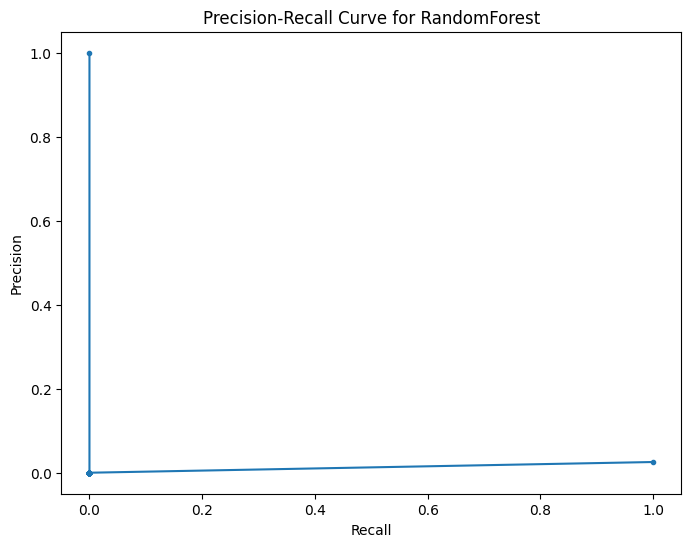

In [30]:
# --- Enhanced Evaluation and Visualization ---

# Model Comparison Table
results_df = pd.DataFrame(results).T
print("\nModel Comparison Table:")
print(results_df)

X_test_imputed = imputer.transform(X_test) # Apply the same imputation used during training
X_test_scaled = scaler.transform(X_test_imputed) # Apply the same scaling used during training

# Precision-Recall Curve for RandomForest
precision, recall, _ = precision_recall_curve(y_test, traditional_models['RandomForest'].predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for RandomForest')
plt.show()

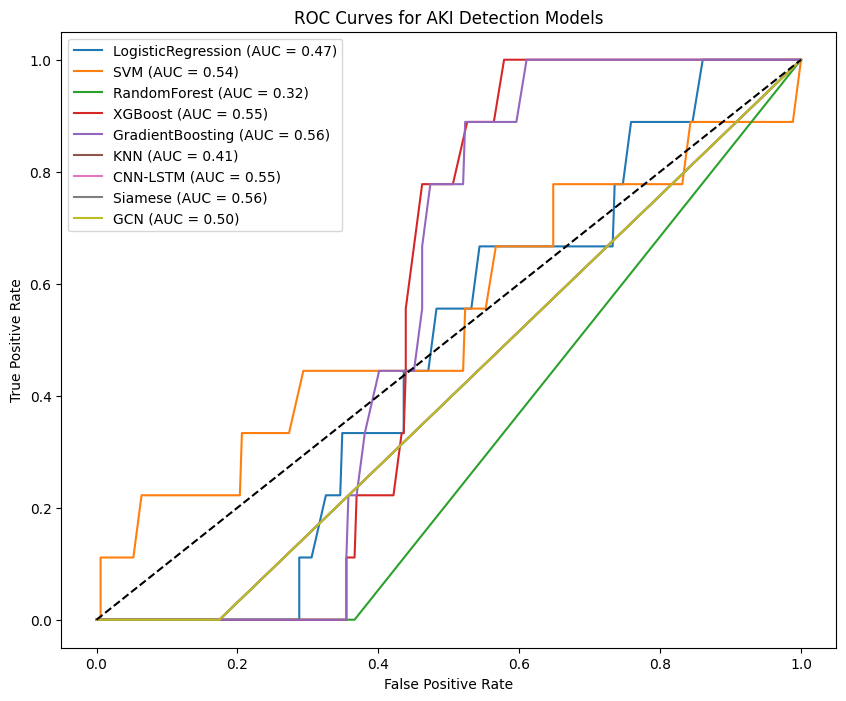

In [32]:
# ROC Curves
plt.figure(figsize=(10, 8))
for name, model in traditional_models.items():
    if hasattr(model, "predict_proba"):
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    else:
        fpr, tpr, _ = roc_curve(y_test, model.decision_function(X_test_scaled))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['ROC AUC']:.2f})")
plt.plot(fpr, tpr, label=f"CNN-LSTM (AUC = {results['CNN-LSTM']['ROC AUC']:.2f})")
plt.plot(fpr, tpr, label=f"Siamese (AUC = {results['Siamese']['ROC AUC']:.2f})")
plt.plot(fpr, tpr, label=f"GCN (AUC = {results['GCN']['ROC AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for AKI Detection Models')
plt.legend()
plt.show()

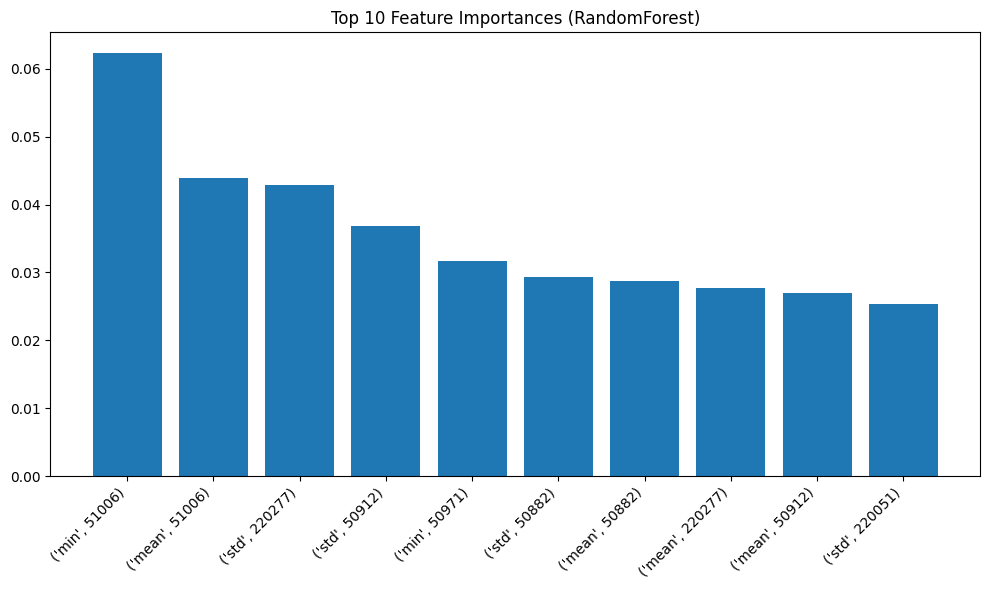

In [33]:
#Feature Importance for RandomForest
importances = traditional_models['RandomForest'].feature_importances_
indices = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances (RandomForest)')
plt.bar(range(10), importances[indices], align='center')
plt.xticks(range(10), X.columns[indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

X_test_scaled shape: (353, 83)
shap_values shape: (353, 83, 2)
shap_values shape: (353, 83, 2)
shap_values[0, :, 1] shape: (83,)


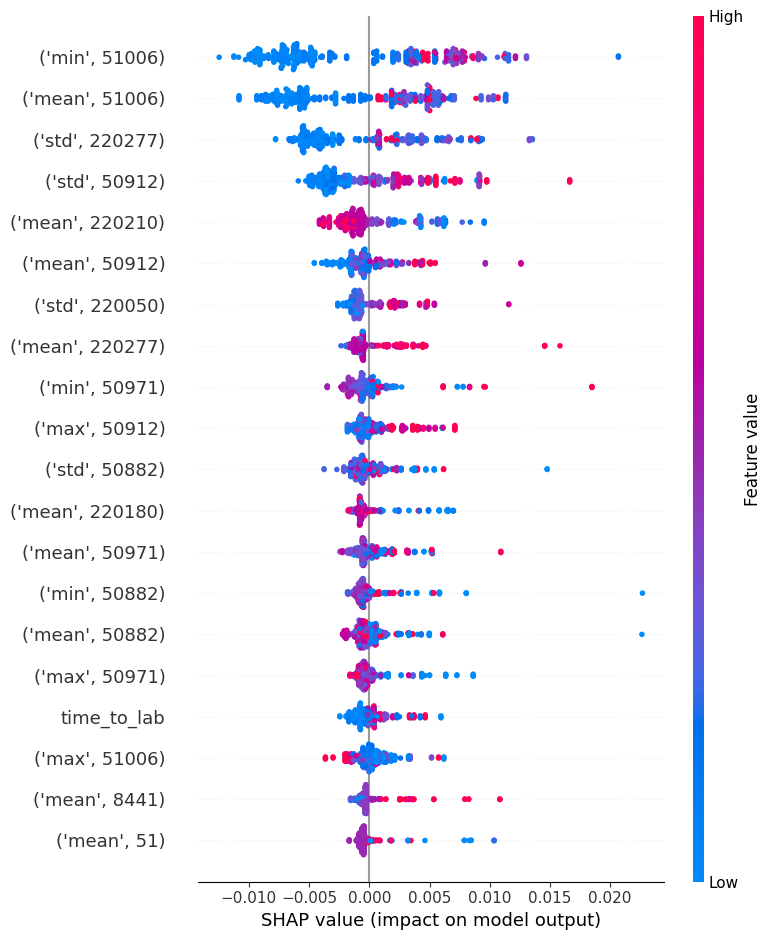

In [69]:
import shap

print("X_test_scaled shape:", X_test_scaled.shape)  # Should be (n_samples, n_features)
print("shap_values shape:", np.array(shap_values).shape)  # Check expected shape
print(f"shap_values shape: {shap_values.shape}")
print(f"shap_values[0, :, 1] shape: {shap_values[0, :, 1].shape}")
# Assume 'model' is your trained RandomForestClassifier and 'X_test' is your test data
explainer = shap.TreeExplainer(traditional_models['RandomForest'])
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot: Overall feature importance
shap.summary_plot(shap_values[:,:,1], X_test_scaled, feature_names=list(X.columns))

# Force plot: Explanation for a single prediction (e.g., first test sample)
#shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test_scaled[0,:], feature_names=X.columns)

#shap.force_plot(    explainer.expected_value[1],    shap_values[1][0],  # Use only class 1's SHAP values    X_test_scaled[0],      feature_names=list(X.columns),    matplotlib=True # Add this parameter )
